# Setup

- http://jupyter.readthedocs.io/en/latest/install.html

```
$ pip install jupyter
$ pip install numpy
$ pip install matplotlib
```

# Miniflow - A simple python code that imitates Tensorflow 

**Disclaimer:** This is pure and so called original work of **Ctrl + C** and **Ctrl + V** ;)

# Machine Learning

- Supervised
- Unsupervised
- Semi Supervised

```
                                            ---------------- 
                                           |                |
                                           v                |
Data -> Preprocessing -> Batching -> Model Training -> Evaluation -> Required Accuracy? -> Deploy


### Model Trianing (Supervised)

(Input Features, Target(s)) -> Intialize Model      ->    Predict the Target ->      Calculate the Error
                               Parameters Randomly                       ^                            |                                                                              |                            |
                                                                         |                            |
                                                                         |                            |
                                                                         |                            |
                                                                          -------Update Parameters----
```

# Lets start with an demo 
- http://playground.tensorflow.org/
- https://www.mathway.com/Algebra
- http://setosa.io/ev/ordinary-least-squares-regression/

### Neural Network Jargons:
- Input Layer
- Output Layer
- Weights
- Bias
- Forward propagation
- Activation Function - Sigmoid
- Backward propagation
- Error Calculation
- Regularization
- Gradient Descent

![](https://qph.ec.quoracdn.net/main-qimg-5285e8d35c8cf10009d9672d7b2c5ac9-c)


### Outline:
- Abstract a simple Neural Node/[Neuron](https://en.wikipedia.org/wiki/Neuron)
    - With some I/O properties
    - How to do a forward pass
    - How to calculate gradients and do backward pass
- Create an Input Node
- Create some operations like Add, Multiply, Liner Tranformation, Sigmoid, Mean Square Error
- Explore how forward pass is done in all the operation
- Learn Mathematics behind Backpropagation (Don't worry even I am scared!)
- Get to see how gradients are caculated
- Explore how it is implemented 
- SGD - A simple algorithm to adapt teh weights for descent predictions

![](w2-backprop-graph.png)

# Software Modeling vs Software Designing


"Modeling" is describing something you know. A good model makes correct assertions. Expressing a scientific theory or algorithm in software. 

Software design is the process of defining software methods, functions, objects, and the overall structure and interaction of your code so that the resulting functionality will satisfy your users requirements.


# Implementing  Neural Node

In [1]:
import numpy as np
import matplotlib.pyplot as plot
%matplotlib inline
DEBUG = True

In [2]:
class Node(object):
    """
    Base class for nodes in the network.
    Should have following properties:
    1. Should hold its value
    2. Should know what are incoming nodes
    3. Should know to which node(s) it outputs the value
    4. Should hold the gradient calculated

    Arguments:

        `inbound_nodes`: A list of nodes with edges into this node.
    """
    def __init__(self, inbound_nodes=[]):
        """
        Node's constructor (runs when the object is instantiated). Sets
        properties that all nodes need.
        """
        self.name = "Node"
        
        # The eventual value of this node. Set by running
        # the forward() method.
        self.value = None
        
        # A list of nodes with edges into this node.
        # Just like input arguments to any function/method
        self.inbound_nodes = inbound_nodes

        # A list of nodes that this node outputs to.
        # Is it possible to know which node I am gonna send the result? Definelty NO!!!
        self.outbound_nodes = []
        
        # Keys are the inputs to this node and
        # their values are the partials of this node with
        # respect to that input.
        self.gradients = {}
        
        # Sets this node as an outbound node for all of
        # this node's inputs.
        # Hey there I am your output node, do send me your results, ok!
        for node in inbound_nodes:
            node.outbound_nodes.append(self)

    def forward(self):
        """
        Every node that uses this class as a base class will
        need to define its own `forward` method.
        """
        raise NotImplementedError

    def backward(self):
        """
        Every node that uses this class as a base class will
        need to define its own `backward` method.
        """
        raise NotImplementedError

In [3]:
class Input(Node):
    """
    A generic input into the network.
    """
    def __init__(self, name='Input'):
        # The base class constructor has to run to set all
        # the properties here.
        #
        # The most important property on an Input is value.
        # self.value is set during `topological_sort` later.
        Node.__init__(self)
        self.name = name

    # NOTE: Input node is the only node where the value
    # may be passed as an argument to forward().
    #
    # All other node implementations should get the value
    # of the previous node from self.inbound_nodes
    #
    # Example:
    # val0 = self.inbound_nodes[0].value
    def forward(self, value=None):
        # Overwrite the value if one is passed in.
        if(DEBUG) : print("\n----->Forward pass @ " ,self.name)
        if value is not None:
            self.value = value
            if(DEBUG) : print("w.r.t {} node of value: {} ".format(self.name, self.value))
            

    def backward(self):
        # An Input node has no inputs so the gradient (derivative)
        # is zero.
        # The key, `self`, is reference to this object.
        self.gradients = {self: 0}
        # Weights and bias may be inputs, so you need to sum
        # the gradient from output gradients.
        if(DEBUG) : print('\n')
        if(DEBUG) : print('=============================\n\tBP @ {}\n=============================\n'.format(self.name))
        if(DEBUG) : print('Initial Gradients:\n------------------')
        if(DEBUG) : print('W.r.t {}: \n------------\n{}'.format(self.name,self.gradients[self]))
            
        for n in self.outbound_nodes:
            grad_cost = n.gradients[self]
            
            if(DEBUG) : print('\n')
            if(DEBUG) : print('Getting ', n.name, 'gradient : \n<-----------------------------\n', grad_cost)
            if(DEBUG) : print('\n')
                
            self.gradients[self] += grad_cost * 1
            
        if(DEBUG) : print('Calculated Final Gradient:(Note: Calculated by next node in the graph!!!)\n----------------')
        if(DEBUG) : print('W.r.t ', self.name, ' : \n-------------\n', self.gradients[self])  


## DAG
- https://en.wikipedia.org/wiki/Directed_acyclic_graph
- https://stackoverflow.com/questions/2283757/can-someone-explain-in-simple-terms-to-me-what-a-directed-acyclic-graph-is

## **Topological sorting:** 
- https://en.wikipedia.org/wiki/Topological_sorting  
- http://www.geeksforgeeks.org/topological-sorting/ (oh ya I need to keep this in my interview preparation!)  
    In order to define your network, you'll need to define the order of operations for your nodes. Given that the input to some node depends on the outputs of others, you need to flatten the graph in such a way where all the input dependencies for each node are resolved before trying to run its calculation. This is a technique called a topological sort.

In [4]:
T_DEBUG = True
def topological_sort(feed_dict):
    """
    Sort the nodes in topological order using Kahn's Algorithm.

    `feed_dict`: A dictionary where the key is a `Input` Node and the value is 
    the respective value feed to that Node.

    Returns a list of sorted nodes.
    """
    if T_DEBUG: print('-----> topological_sort')
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    
    if T_DEBUG: print('Input Nodes:'); [print(n.name) for n in input_nodes]
        
    while len(nodes) > 0:
        n = nodes.pop(0)
        
        if T_DEBUG: print('Pop: ', n.name)
            
        if n not in G:
            if T_DEBUG: print('Adding: ', n.name, 'to the Graph')
            G[n] = {'in': set(), 'out': set()}
            
        for m in n.outbound_nodes:
            if m not in G: 
                if T_DEBUG: print('Adding: ', m.name, 'to the Graph')
                G[m] = {'in': set(), 'out': set()}
                
            G[n]['out'].add(m); 
            if T_DEBUG: print('Adding', n.name, '----->', m.name)
                
            G[m]['in'].add(n); 
            if T_DEBUG: print('Adding', m.name, '<-----', n.name)
                
            nodes.append(m)
            if T_DEBUG: print('Appending ', m.name)
          
    L = []
    S = set(input_nodes)
    if T_DEBUG: print('Input Nodes:'); [print(n.name) for n in S]
    while len(S) > 0:
        n = S.pop()
        if T_DEBUG: print('Pop: ', n.name)

        #Assign values to the input node
        if isinstance(n, Input):
            if T_DEBUG: print('Feeding value: ', feed_dict[n], ' =====>  ', n.name)
            n.value = feed_dict[n]

        L.append(n)
        if T_DEBUG: print('Adding ', n.name, 'to the sorted List')
        for m in n.outbound_nodes:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if T_DEBUG: print('Removing', n.name, '----->', m.name)
            if T_DEBUG: print('Removing', m.name, '<-----', n.name)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                if T_DEBUG: print('\nNo input nodes!!! Adding: ', m.name, 'to the Graph\n')
                S.add(m)
    
    if T_DEBUG: print('Sorted Nodes:\n'); [print(n.name) for n in L]
    
    if T_DEBUG: print('<------------------------------------ topological_sort')
        
    return L

In [5]:
def forward_pass(output_node, sorted_nodes):
    """
    Performs a forward pass through a list of sorted nodes.

    Arguments:

        `output_node`: A node in the graph, should be the output node (have no outgoing edges).
        `sorted_nodes`: A topologically sorted list of nodes.

    Returns the output Node's value
    """

    for n in sorted_nodes:
        n.forward()

    return output_node.value

# Lets define our Operations

In [6]:
class Add(Node):
    def __init__(self, *inputs):
        Node.__init__(self, inputs)
        self.name = "Add_Op"

    def forward(self):
        """
        For reference, here's the old way from the last
        quiz. You'll want to write code here.
        """
        self.value = 0
        for i in range(len(self.inbound_nodes)):
            
            if(DEBUG) : print("Initial value of {} is {}".format(self.name, self.value))
                
            self.value +=  self.inbound_nodes[i].value
            
            if(DEBUG) : print("{}:{} ---> {}:{}".format(self.inbound_nodes[i].name, self.inbound_nodes[i].value, 
                                           self.name, self.value))
            



In [7]:
x, y, z = Input('x'), Input('y'), Input('z')

f = Add(x, y, z)
feed_dict = {x: 4, y: 5, z: 10}
graph = topological_sort(feed_dict)
addition_res = forward_pass(f, graph)
# should output 19
print("{} + {} + {} = {} (according to miniflow)".format(feed_dict[x], feed_dict[y], feed_dict[z], addition_res))


-----> topological_sort
Input Nodes:
x
y
z
Pop:  x
Adding:  x to the Graph
Adding:  Add_Op to the Graph
Adding x -----> Add_Op
Adding Add_Op <----- x
Appending  Add_Op
Pop:  y
Adding:  y to the Graph
Adding y -----> Add_Op
Adding Add_Op <----- y
Appending  Add_Op
Pop:  z
Adding:  z to the Graph
Adding z -----> Add_Op
Adding Add_Op <----- z
Appending  Add_Op
Pop:  Add_Op
Pop:  Add_Op
Pop:  Add_Op
Input Nodes:
y
z
x
Pop:  y
Feeding value:  5  =====>   y
Adding  y to the sorted List
Removing y -----> Add_Op
Removing Add_Op <----- y
Pop:  z
Feeding value:  10  =====>   z
Adding  z to the sorted List
Removing z -----> Add_Op
Removing Add_Op <----- z
Pop:  x
Feeding value:  4  =====>   x
Adding  x to the sorted List
Removing x -----> Add_Op
Removing Add_Op <----- x

No input nodes!!! Adding:  Add_Op to the Graph

Pop:  Add_Op
Adding  Add_Op to the sorted List
Sorted Nodes:

y
z
x
Add_Op
<------------------------------------ topological_sort

----->Forward pass @  y

----->Forward pass @  z



In [8]:
T_DEBUG = False

In [9]:
class Mul(Node):
    def __init__(self, *inputs):
        Node.__init__(self, inputs)
        self.name = "Mul_Op"

    def forward(self):
        """
        For reference, here's the old way from the last
        quiz. You'll want to write code here.
        """
        self.value = 1
        for i in range(len(self.inbound_nodes)):
            if(DEBUG) : print("Initial value of {} is {}".format(self.name, self.value))
                
            self.value *=  self.inbound_nodes[i].value
            
            if(DEBUG) : print("{}:{} ---> {}:{}".format(self.inbound_nodes[i].name, self.inbound_nodes[i].value, 
                                           self.name, self.value))
            
        # x_value = self.inbound_nodes[0].value
        # y_value = self.inbound_nodes[1].value
        # self.value = x_value + y_value

In [10]:
x, y, z = Input('x'), Input('y'), Input('z')
f1 = Mul(x, y, z)
feed_dict = {x: 4, y: 5, z: 10}
graph = topological_sort(feed_dict)
product = forward_pass(f1, graph)
# should output 19
print("\n{} * {} * {} = {} (according to miniflow)".format(feed_dict[x], feed_dict[y], feed_dict[z], product))



----->Forward pass @  z

----->Forward pass @  y

----->Forward pass @  x
Initial value of Mul_Op is 1
x:4 ---> Mul_Op:4
Initial value of Mul_Op is 4
y:5 ---> Mul_Op:20
Initial value of Mul_Op is 20
z:10 ---> Mul_Op:200

4 * 5 * 10 = 200 (according to miniflow)


### Linear Transformation
A simple artificial neuron depends on three components:

- inputs, $x_i$
- weights, $w_i$ 
- bias, $b$

The output, $y$, is just the weighted sum of the inputs plus the bias.

$$y =\sum_i x_iw_i + b$$

Gradient:

$$\frac{\partial y}{\partial X} = W$$
$$\frac{\partial y}{\partial W} = X$$
$$\frac{\partial y}{\partial b} = 1$$

![drawing](https://algebra1course.files.wordpress.com/2013/02/slide11.jpg)


In [11]:
a = np.array([[1,2],[3,4]])
b = np.array([[5,6],[7,8]])
np.dot(a,b)

array([[19, 22],
       [43, 50]])

In [12]:
class Linear(Node):
    """
    Represents a node that performs a linear transform.
    """
    def __init__(self, X, W, b):
        # The base class (Node) constructor. Weights and bias
        # are treated like inbound nodes.
        Node.__init__(self, [X, W, b])
        self.name = "Linear_OP"

    def forward(self):
        """
        Performs the math behind a linear transform.
        """
        self.X = self.inbound_nodes[0]
        self.W = self.inbound_nodes[1]
        self.b = self.inbound_nodes[2]

        self.value = np.dot(self.X.value,self.W.value) + self.b.value
        

        
        if(DEBUG) :  print("\n----->Forward pass @ " ,self.name)
        if(DEBUG) : print("{}:\n{} * \n{}:\n{} + \n{}:\n{} =\n {}:\n{}".format(self.X.name,self.X.value,
                                                                  self.W.name, self.W.value,
                                                                  self.b.name, self.b.value,
                                                                  self.name, self.value))

    def backward(self):
        """
        Calculates the gradient based on the output values.
        """
        # Initialize a partial for each of the inbound_nodes.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_nodes}
        # Cycle through the outputs. The gradient will change depending
        # on each output, so the gradients are summed over all outputs.
        
        if(DEBUG) : print('\n')
        if(DEBUG) : print('=============================\n\tBP @ Linear\n=============================\n')
        if(DEBUG) : print('Initial Gradients:\n------------------')
        if(DEBUG) : print('W.r.t {}: \n---------------\n{}'.format(self.X.name, self.gradients[self.X]))
        if(DEBUG) : print('W.r.t {}: \n---------------\n{}'.format(self.W.name, self.gradients[self.W]))
        if(DEBUG) : print('W.r.t {}: \n---------------\n{}'.format(self.b.name, self.gradients[self.b]))
            
        for n in self.outbound_nodes:
            # Get the partial of the cost with respect to this node.
            # The out is mostly only one node, a activation function!(sigmoid here)
            grad_cost = n.gradients[self]
            
            if(DEBUG) : print('\n')
            if(DEBUG) : print('Getting ', n.name, 'gradient is : \n<-----------------------------\n', grad_cost)
            if(DEBUG) : print('\n')
                
            # Get the gradient for this node from next node and respective operation 
            # (mutliply/add) with each input of this node to set their respective gradients
            # Set the partial of the loss with respect to this node's inputs.
            self.gradients[self.X] += np.dot(grad_cost, self.W.value.T)
            # Set the partial of the loss with respect to this node's weights.
            self.gradients[self.W] += np.dot(self.X.value.T, grad_cost)
            # Set the partial of the loss with respect to this node's bias.
            self.gradients[self.b] += np.sum(grad_cost, axis=0, keepdims=False)
            
        if(DEBUG) : print('Calculated Final Gradient:\n----------------')
        if(DEBUG) : print('W.r.t ',self.X.name,': \n-------------\n', self.gradients[self.inbound_nodes[0]])
        if(DEBUG) : print('W.r.t ',self.W.name,': \n-------------\n', self.gradients[self.inbound_nodes[1]])
        if(DEBUG) : print('W.r.t ',self.b.name,': \n-------------\n', self.gradients[self.inbound_nodes[2]])

![](w2-backprop-graph.png)

In [13]:
X, W, b = Input('X'), Input('W'), Input('b')

f = Linear(X, W, b)

X_ = np.array([[1., 2.], [3., 4.]])
W_ = np.array([[5., 6.], [7., 8.]])
b_ = np.array([-1., -1])

feed_dict = {X: X_, W: W_, b: b_}

graph = topological_sort(feed_dict)
output = forward_pass(f, graph)

print("\n\noutput: \n", output)


----->Forward pass @  X

----->Forward pass @  W

----->Forward pass @  b

----->Forward pass @  Linear_OP
X:
[[ 1.  2.]
 [ 3.  4.]] * 
W:
[[ 5.  6.]
 [ 7.  8.]] + 
b:
[-1. -1.] =
 Linear_OP:
[[ 18.  21.]
 [ 42.  49.]]


output: 
 [[ 18.  21.]
 [ 42.  49.]]


### Sigmoid

https://en.wikipedia.org/wiki/Sigmoid_function

$$ S(x) = \frac{1}{1+e^{-x}} $$

Gradient: $\frac{\partial S(x)}{\partial x} = S(x) * (1-S(x))$

$\frac{\partial cost}{\partial S(x)} = grad\_cost$



In [14]:
class Sigmoid(Node):
    """
    Represents a node that performs the sigmoid activation function.
    """
    def __init__(self, node):
        # The base class constructor.
        Node.__init__(self, [node])
        self.name = "Sigmoid_Op"

    def _sigmoid(self, x):
        """
        This method is separate from `forward` because it
        will be used with `backward` as well.

        `x`: A numpy array-like object.
        """
        return 1. / (1. + np.exp(-x))

    def forward(self):
        """
        Perform the sigmoid function and set the value.
        """
        if(DEBUG) : print("\n----->Forward pass @ " ,self.name)
        if(DEBUG) : print("Initial value of {} is {}".format(self.name, self.value))
        input_value = self.inbound_nodes[0].value
        self.value = self._sigmoid(input_value)
        if(DEBUG) : print("{}:\n{} ---> {}:\n{}".format(self.inbound_nodes[0].name, self.inbound_nodes[0].value, 
                                           self.name, self.value))

    def backward(self):
        """
        Calculates the gradient using the derivative of
        the sigmoid function.
        """
        # Initialize the gradients to 0.
        self.gradients = {n: np.zeros_like(n.value) for n in self.inbound_nodes}

        if(DEBUG) : print('\n')
        if(DEBUG) : print('=============================\n\tBP @ Sigmoid\n=============================\n')
        if(DEBUG) : print('Initial Gradients:\n------------------')
        if(DEBUG) : print('W.r.t ', self.inbound_nodes[0].name, ': \n----------------\n', self.gradients[self.inbound_nodes[0]])
        
        # Cycle through the outputs. The gradient will change depending
        # on each output, so the gradients are summed over all outputs.
        for n in self.outbound_nodes:
            # Get the partial of the cost with respect to this node.
            grad_cost = n.gradients[self] #For eg. get it from MSE
            
            if(DEBUG) : print('\n')
            if(DEBUG) : print('Getting ', n.name, 'gradient : \n<-----------------------------\n', grad_cost)
            if(DEBUG) : print('\n')
                
            sigmoid = self.value
            self.gradients[self.inbound_nodes[0]] += sigmoid * (1 - sigmoid) * grad_cost
            
        if(DEBUG) : print('Calculated Final Gradient:')
        if(DEBUG) : print('--------------------------')
        if(DEBUG) : print('W.r.t ',self.inbound_nodes[0].name,': \n-------------\n', self.gradients[self.inbound_nodes[0]])    




In [15]:
X, W, b = Input('X'), Input('W'), Input('b')

f = Linear(X, W, b)
g = Sigmoid(f)

X_ = np.array([[-1., -2.], [-1, -2]])
W_ = np.array([[2., -3], [2., -3]])
b_ = np.array([-3., -5])

feed_dict = {X: X_, W: W_, b: b_}

graph = topological_sort(feed_dict)
output = forward_pass(g, graph)

"""
Output should be:
[[  1.23394576e-04   9.82013790e-01]
 [  1.23394576e-04   9.82013790e-01]]
"""
print("\n\noutput: \n", output)



----->Forward pass @  W

----->Forward pass @  X

----->Forward pass @  b

----->Forward pass @  Linear_OP
X:
[[-1. -2.]
 [-1. -2.]] * 
W:
[[ 2. -3.]
 [ 2. -3.]] + 
b:
[-3. -5.] =
 Linear_OP:
[[-9.  4.]
 [-9.  4.]]

----->Forward pass @  Sigmoid_Op
Initial value of Sigmoid_Op is None
Linear_OP:
[[-9.  4.]
 [-9.  4.]] ---> Sigmoid_Op:
[[  1.23394576e-04   9.82013790e-01]
 [  1.23394576e-04   9.82013790e-01]]


output: 
 [[  1.23394576e-04   9.82013790e-01]
 [  1.23394576e-04   9.82013790e-01]]


### MSE (Cost/Loss)
- (https://en.wikipedia.org/wiki/Linear_regression)
- http://setosa.io/ev/ordinary-least-squares-regression/

$MSE(\theta) = \frac{1}{N} \sum_{i=1}^N \left (f(y_i|\theta)-a_i \right )^2$

$f(y_i|\theta)$ is a function that calculates $y_i$ with parameters $\theta$ or weights, what it had learned already

Gradient:

With respect to y: $\frac{2}{N}(y-a)$   
With respect to a: $\frac{-2}{N}(y-a)$

In [16]:
class MSE(Node):
    def __init__(self, y, a):
        """
        The mean squared error cost function.
        Should be used as the last node for a network.
        """
        # Call the base class' constructor.
        Node.__init__(self, [y, a])
        self.name = "MSE_Op"
        

    def forward(self):
        """
        Calculates the mean squared error.
        """
        # NOTE: We reshape these to avoid possible matrix/vector broadcast
        # errors.
        #
        # For example, if we subtract an array of shape (3,) from an array of shape
        # (3,1) we get an array of shape(3,3) as the result when we want
        # an array of shape (3,1) instead.
        #
        # Making both arrays (3,1) insures the result is (3,1) and does
        # an elementwise subtraction as expected.
        if(DEBUG) : print("\n----->Forward pass @ " ,self.name)
        if(DEBUG) : print("Initial value of {} is {}".format(self.name, self.value))
            
        y = self.inbound_nodes[0].value.reshape(-1, 1)
        a = self.inbound_nodes[1].value.reshape(-1, 1)

        self.m = self.inbound_nodes[0].value.shape[0]
        # Save the computed output for backward.
        self.diff = y - a
        self.value = np.mean(np.square(self.diff))
        
        if(DEBUG) : print("{}:\n{} - \n{}:\n{} =\n {}:\n{}".format(self.inbound_nodes[0].name,y,
                                                                  self.inbound_nodes[1].name, a,
                                                                  self.name, self.value))
    def backward(self):
        """
        Calculates the gradient of the cost.

        This is the final node of the network so outbound nodes
        are not a concern.
        """
        if(DEBUG) : print('\n')
        if(DEBUG) : print('=============================\n\tBP @ MSE\n=============================\n')
        if(DEBUG) : print('Initial Gradients:\n------------------')
        if(DEBUG) : print('Nothing! Since this node will be the last node!!!\n')
        
        self.gradients[self.inbound_nodes[0]] = (2 / self.m) * self.diff
        self.gradients[self.inbound_nodes[1]] = (-2 / self.m) * self.diff #for eg. this goes back to Sigmoid
        
        if(DEBUG) : print('Calculated Final Gradient:\n----------------')
        if(DEBUG) : print('W.r.t ',self.inbound_nodes[0].name,': \n------------------\n', self.gradients[self.inbound_nodes[0]])
        if(DEBUG) : print('W.r.t ',self.inbound_nodes[1].name,': \n------------------\n', self.gradients[self.inbound_nodes[1]])


In [17]:
y, a = Input('y'), Input('a')
cost = MSE(y, a)

y_ = np.array([1, 2, 3])
a_ = np.array([4.5, 5, 10])

feed_dict = {y: y_, a: a_}
graph = topological_sort(feed_dict)
# forward pass
# forward_pass_mse(graph)
forward_pass(cost, graph)
"""
Expected output

23.4166666667
"""
print(cost.value)




----->Forward pass @  y

----->Forward pass @  a

----->Forward pass @  MSE_Op
Initial value of MSE_Op is None
y:
[[1]
 [2]
 [3]] - 
a:
[[  4.5]
 [  5. ]
 [ 10. ]] =
 MSE_Op:
23.416666666666668
23.4166666667


# 2. Backpropagation
- Partial Differentiation
    - https://math.stackexchange.com/questions/45952/why-do-we-take-a-derivative
    - https://simple.wikipedia.org/wiki/Derivative_(mathematics)
    - https://en.wikipedia.org/wiki/Partial_derivative
    - https://en.wikipedia.org/wiki/Chain_rule

    
Khan Academy:    
- https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/partial-derivatives/v/partial-derivatives-introduction   
- https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/gradient-and-directional-derivatives/v/gradient     
- https://www.khanacademy.org/math/ap-calculus-ab/ab-derivative-rules/ab-chain-rule/v/chain-rule-introduction   

Rerferences:
- http://cs231n.github.io/optimization-2/
- https://en.wikipedia.org/wiki/Backpropagation

With ASCII Art:

```
  -2
  x--------
  -4       \ 
            \  -----  q 3
              |  +  | -----
            /  -----   -4   \
   5       /                 \
  y--------                   \  -----  -12
   -4                           |  *  | ----- f(x,y,z) = (x+y)z
                              /  -----    1
                             /
   -4                       /  
  z-------------------------
    3
```   


Let $f(x,y,z) = (x+y)z$ be some function that calculates some error.

$Eg.\ values: x = -2, y = 5, z = -4$

$
Let\ q = x + y \\
Partial\ derivatives...\\
\frac{\partial q}{\partial x} = 1 \\
\frac{\partial q}{\partial y} = 1
$

$
Now\ f = qz \\
Partial\ derivatives...\\
\frac{\partial f}{\partial q} = z = -4 \\
\frac{\partial f}{\partial z} = q = 3
$

How much does each of x,y,z contributed to f,

i.e
$
\frac{\partial f}{\partial x} \
\frac{\partial f}{\partial y} \
\frac{\partial f}{\partial z} 
$

We know that $\frac{\partial f} {\partial f} = 1$

Chain rule:  
$\frac{\partial f}{\partial y} = \frac{\partial f}{\partial q} \frac{\partial q}{\partial y} = -4 . 1 = -4$

$\frac{\partial f}{\partial x} = \frac{\partial f}{\partial q} \frac{\partial q}{\partial x} = -4 . 1 = -4$


![](gradients_in_graph.png)

In [18]:
# **Another Example **
# ![](back_prop_example1.png)

In [19]:
# ![](back_prop_example1_sol.png)

In [20]:
def forward_and_backward(graph):
    """
    Performs a forward pass and a backward pass through a list of sorted Nodes.

    Arguments:

        `graph`: The result of calling `topological_sort`.
    """
    # Forward pass
    for n in graph:
        n.forward()

    # Backward pass
    # see: https://docs.python.org/2.3/whatsnew/section-slices.html
    for n in graph[::-1]:
        n.backward()


Let's consider a network with a linear node $l_1$, a sigmoid node $s$, and another linear node $l_2$, followed by an MSE node to calculate the cost, $C$.

![](two-layer-graph.png)

We can see that each of the values of these nodes flows forwards and eventually produces the cost $C$. 
For example, the value of the second linear node $l_2$ goes into the cost node and determines the value of that node. Accordingly, a change in $l_2$ will produce a change in $C$. We can write this relationship between the changes as a gradient,

$$\frac{\partial C}{\partial l_2}$$

This is what a gradient means, it's a slope, how much you change the cost $\partial C$ given a change in $l_2$, $\partial l_2$. So a node with a larger gradient with respect to the cost is going to contribute a larger change to the cost. In this way, we can assign blame for the cost to each node. The larger the gradient for a node, the more blame it gets for the final cost. And the more blame a node has, the more we'll update it in the gradient descent step.

If we want to update one of the weights with gradient descent, we'll need the gradient of the cost with respect to those weights. Let's see how we can use this framework to find the gradient for the weights in the second layer, $w_2$. We want to calculate the gradient of $C$ with respect to $w_2$:

$\frac{\partial C}{\partial w_2}$

We can see in the graph that $w_2$ is connected to $l_2$, so a change in $w_2$ is going to create a change in $l_2$ which then creates a change in $C$. We can assign blame to $w_2$ by sending the cost gradient back through the network. First you have how much $l_2$ affected $C$, then how much $w_2$ affected $l_2$. Multiplying these gradients together gets you the total blame attributed to $w_2$.

![](w2-backprop-graph.png)

Multiplying these gradients is just an application of the chain rule:
$$\frac{\partial C}{\partial w_2} = \frac{\partial C}{\partial l_2} * \frac{\partial l_2}{\partial w_2}$$


You can see in the graph $w_2$, $l_2$, and $C$ are chained together. Any change in $w_2$ will create a change in $l_2$ and the size of that change is given by the gradient $∂l_2/∂w_2$. Now, since $l_2$ is changing this will cause a change in the cost $C$ and the size of that change is given by the gradient $∂C/∂l_2$. You can think of the chain rule similarly to the domino effect, changing something in the network will propagate through it altering other nodes along the way.
If you think of the chain rule as normal fractions, you can see that $∂l_2$ in the denominator and numerator cancel out and you get back $∂C/∂w_2$ (although it doesn't exactly work like normal fractions, but it helps to keep track of things.) Okay, let's work out the gradient for $w_2$. First, we need to know the gradient for $l_2$.


Cost $C = \frac{1}{m} \sum_x (y(x) - l_2)^2$

And the value for the second linear node is $l_2 = w_2 . s + b_2$

where $w_2$, $s$, and $b_2$ are all vectors and $w_2 . s$ means the dot product of $w_2$ and $s$.

$$
\frac{\partial C}{\partial l_2} = \frac{\partial}{\partial l_2}\Bigg[ \frac{1}{m} \sum_x (y(x) - l_2)^2\Bigg]
= \frac{-2}{m}\sum_x (y(x) - l_2)
$$
$$
\frac{\partial l_2}{\partial w_2} = \frac{\partial}{\partial w_2}\bigg[ w_2 . s + b_2\bigg] = s
$$

And putting these together, you get the gradient for $w_2$

$$
\frac{\partial C}{\partial w_2} = \frac{-2}{m}\sum_x (y(x) - l_2) s
$$

This is the gradient you use in the gradient descent update for $w_2$. You can see what we did here, we walked back through the graph and multiplied all the gradients we found along the way.
Now, let's go deeper and calculate the gradient for $w_1$. Here we use the same method as before, walking backwards through the graph.

![](w1-backprop-graph.png)


Hopefully it's clear now how to write out the gradient for $w_1$ just by looking at the graph. Using the chain rule, we'll write out the gradients for each node going backwards through the graph until we get to $w_1$.

$$
\frac{\partial C}{\partial w_1} = \frac{\partial C}{\partial l_2} \frac{\partial l_2}{\partial s} \frac{\partial s}{\partial l_1} \frac{\partial l_1}{\partial w_1}
$$

Now we can start calculating each gradient in this expression to get the gradient for $w_1$

$$
\frac{\partial l_2}{\partial s} = \frac{\partial }{\partial s} \bigg[ w_2 . s + b_2 \bigg] = w2
$$

The next part is the gradient of the sigmoid function, $s=f(l_1)$. Since we're using the logistic function here, the derivative can be written in terms of the sigmoid itself

$$
\frac{\partial s}{\partial l_1} = \frac{\partial }{\partial l_1}f(l_1)
= f(l_1)(1-f(l_1))
$$

$$
\frac{\partial l_1}{\partial w_1} = \frac{\partial }{\partial w_1} \bigg[ w_1 . x + b_1 \bigg] = x
$$

Putting this all together, you get

$$
\frac{\partial C}{\partial w_1} = \frac{-2}{m}\sum_x (y(x) - l_2) . w2 . f(l_1). (1-f(l_1)) . x
$$

Now we can see a clear pattern. To find the gradient, you just multiply the gradients for all nodes in front of it going backwards from the cost. This is the idea behind backpropagation. The gradients are passed backwards through the network and used with gradient descent to update the weights and biases. If a node has multiple outgoing nodes, you just sum up the gradients from each node.

In [21]:
T_DEBUG = False
DEBUG = True

In [22]:
#Placeholders
X = Input('X') # 2 x 2
y = Input('y') # 2 x 1
W1 = Input('W1') # 2 x 1
b = Input('b') # 1 x 1

#Graph Operations
f1 = Linear(X, W1, b) # 2 x 2 . 2 x 1 + 1 x 1 = 2 x 1 
activation_output = Sigmoid(f1) # 2 x 1


X_ = np.array([[-1., -2.], [-1, -2]])
W1_ = np.array([[2.], [3.]])
b_ = np.array([-3.])
y_ = np.array([1, 2])

if True: #For simple graph
    cost = MSE(y, activation_output) # 2 x 1
    feed_dict = {
        X: X_,
        y: y_,
        W1: W1_,
        b: b_,
    }
    graph = topological_sort(feed_dict)
    forward_and_backward(graph)
    # return the gradients for each Input
    gradients = [t.gradients[t] for t in [X, y, W1, b]]
else: #For the once explained above!
    W2 = Input('W2') 
    W2_ = np.array([[2.]]) # 1 x 1
    b2 = Input('b2') 
    b2_ = np.array([-3.]) # 1,
    
    f2 = Linear(activation_output, W2, b2) # 2 x 1 . 1 x 1 + 1 x 1 = 2 x 1
    cost = MSE(y, f2) # 2 x 1 - 2 x 1

    feed_dict = {
        X: X_,
        y: y_,
        W1: W1_,
        b: b_,
        W2: W2_,
        b2: b2_
    }
    graph = topological_sort(feed_dict)
    forward_and_backward(graph)
    # return the gradients for each Input
    gradients = [t.gradients[t] for t in [X, y, W1, b, W2, b2]]
 
"""
Expected output for case 1:

[array([[ -3.34017280e-05,  -5.01025919e-05],
       [ -6.68040138e-05,  -1.00206021e-04]]), 
 array([[ 0.9999833],
       [ 1.9999833]]), 
 array([[  5.01028709e-05],
       [  1.00205742e-04]]), 
 array([ -5.01028709e-05])
]
"""
print('\n\n', gradients)


----->Forward pass @  y

----->Forward pass @  b

----->Forward pass @  X

----->Forward pass @  W1

----->Forward pass @  Linear_OP
X:
[[-1. -2.]
 [-1. -2.]] * 
W1:
[[ 2.]
 [ 3.]] + 
b:
[-3.] =
 Linear_OP:
[[-11.]
 [-11.]]

----->Forward pass @  Sigmoid_Op
Initial value of Sigmoid_Op is None
Linear_OP:
[[-11.]
 [-11.]] ---> Sigmoid_Op:
[[  1.67014218e-05]
 [  1.67014218e-05]]

----->Forward pass @  MSE_Op
Initial value of MSE_Op is None
y:
[[1]
 [2]] - 
Sigmoid_Op:
[[  1.67014218e-05]
 [  1.67014218e-05]] =
 MSE_Op:
2.4999498960133932


	BP @ MSE

Initial Gradients:
------------------
Nothing! Since this node will be the last node!!!

Calculated Final Gradient:
----------------
W.r.t  y : 
------------------
 [[ 0.9999833]
 [ 1.9999833]]
W.r.t  Sigmoid_Op : 
------------------
 [[-0.9999833]
 [-1.9999833]]


	BP @ Sigmoid

Initial Gradients:
------------------
W.r.t  Linear_OP : 
----------------
 [[ 0.]
 [ 0.]]


Getting  MSE_Op gradient : 
<-----------------------------
 [[-0.99998

# 3. SGD with Boston Dataset
- https://www.youtube.com/watch?v=GCvWD9zIF-s
- https://imgur.com/SmDARzn

### [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent)
$$x = x - learning\ rate * \frac{\partial cost}{\partial x}$$


Stochastic Gradient Descent
Stochastic Gradient Descent (SGD) is a version of Gradient Descent where on each forward pass a batch of data is randomly sampled from total dataset. Remember when we talked about the batch size earlier? That's the size of the batch. Ideally, the entire dataset would be fed into the neural network on each forward pass, but in practice, it's not practical due to memory constraints. SGD is an approximation of Gradient Descent, the more batches processed by the neural network, the better the approximation.

A naïve implementation of SGD involves:

1. Randomly sample a batch of data from the total dataset.
2. Running the network forward and backward to calculate the gradient (with data from (1)).
3. Apply the gradient descent update.
4. Repeat steps 1-3 until convergence or the loop is stopped by another mechanism (i.e. the number of epochs).


If all goes well, the network's loss should generally trend downwards, indicating more useful weights and biases over time.



### Simple Example

$$f(x)=x^4−3x^3+2$$

And its derivative
$$f'(x)=4x^3−9x^2$$

In [23]:
# The gradient descent algorithm is applied to find a local minimum of the function f(x)=x^4−3x^3+2, with derivative
#f'(x)=4x^3−9x^2. Here is an implementation in the Python programming language.
# From calculation, it is expected that the local minimum occurs at x=9/4

cur_x = 6 # The algorithm starts at x=6
gamma = 0.01 # step size multiplier
precision = 0.00001
previous_step_size = cur_x

def df(x):
    return 4 * x**3 - 9 * x**2

while previous_step_size > precision:
    prev_x = cur_x
    cur_x += -gamma * df(prev_x)
    previous_step_size = abs(cur_x - prev_x)

print("The local minimum occurs at %f" % cur_x)

The local minimum occurs at 2.249965


In [24]:
def sgd_update(trainables, learning_rate=1e-2):
    """
    Updates the value of each trainable with SGD.

    Arguments:

        `trainables`: A list of `Input` Nodes representing weights/biases.
        `learning_rate`: The learning rate.
    """
    # Performs SGD
    #
    # Loop over the trainables
    for t in trainables:
        # Change the trainable's value by subtracting the learning rate
        # multiplied by the partial of the cost with respect to this
        # trainable.
        partial = t.gradients[t]
        t.value -= learning_rate * partial

In [25]:
T_DEBUG = False
DEBUG = False

In [26]:
"""
Have fun with the number of epochs!

Be warned that if you increase them too much,
logs will overshoot :)
"""

import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
# from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1] # 13
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 100
# Total number of examples
m = X_.shape[0] # 506
batch_size = 11
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

total_loss = []

# Step 4
for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        forward_and_backward(graph)

        # Step 3
        sgd_update(trainables)

        loss += graph[-1].value
        

#     print("=======> Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
    total_loss.append(loss/steps_per_epoch)


Total number of examples = 506


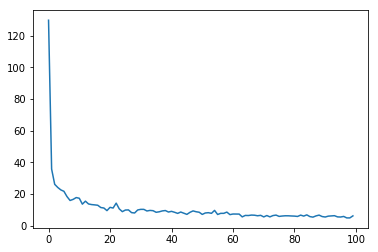

In [27]:
plot.plot(range(len(total_loss)), total_loss)